# **Baseline Models Demo**  
_**A Walkthrough of Training and Evaluating 2 Baseline Models for the SLIPP Project**_

> Estimated reading time: 15-30 minutes
> 
> Author: Shirley Zhang
> 
> Date: June 2023


[Source Code: `/src/Baselines/models.py`](../src/Baselines/models.py)

[Documentation: `/docs/guides/Baselines/models.md`](../docs/guides/Baselines/models.md)

## **Introduction**

<div class="alert alert-block alert-info">

#### **Background:**

Baseline models are an essential part of building machine learning (ML) models, as they serve as benchmarks to evaluate how well our more complex ML models are doing. In this project, we decided to implement two classes of baselines: 

<u>1. Mean Baseline</u>
- Means are simple and quick to calculate and commonly used as a baseline in ML pipelines. Since our variables have spatial and temporal dimensions, we decided to try predicting three differenc types of means, from least to most complex: 
  - `overall_mean`: predicts one value; the mean of the entire training set.
  - `latlon_mean`: predicts a mean for each latitude and longitude point across all time points (from the training set).
  - `latlonmonth_mean`: predicts predicts a mean for each latitude and longitude point for each month (from the training set).
- If using this class as a baseline, we recommend using the `latlonmonth_mean` prediction as it may be the most accurate. 

<u>2. OLS Baseline</u> 
- Previous research has used ordinary least squares (OLS) linear regression to relate $\delta^{18}O$ to temperature (Stenni et al., 2017). We hope to improve and build upon these efforts, and thus build an OLS model as a baseline.
    - The linear regression model from Stenni et al., 2017 related regional $\delta^{18}O$ values to regional temperature:
$$T_{region} = \alpha_{region}\delta^{18}O_{region}$$
Our model is slightly simpler, removing the regional component and simply relating an x-variable to a climate y-variable. We also add an intercept:
$$y_i = \beta_0 + \beta_1x$$
Where $y_i$ is a climate variable, $\beta_0$ is the intercept, $\beta_1$ is the slope, and $x$ is the x-variable.

#### **Implementation:**

There are two Python scripts for the Baseline module: 
1. [`/src/Baselines/models.py`](../src/Baselines/models.py)
    - Contains all of the code for the classes 
2. [`/src/Baselines/scripts/bl_main.py`](../src/Baselines/scripts/bl_main.py)
   - A script which can be used to run the baseline models from the command line ([instructions here](...))

The implementation of the two baseline model classes were inspired by the [Sci-kit Learn](https://scikit-learn.org/stable/index.html) machine learning models. Specifically, the classes follow the structure:
  
> 1. Create and initialize the model
> 2. Fit the model to the training data
> 3. Predict the fitted model on the validation/testing data
    
Both classes have options to return predictions as a numpy array or an xarray dataset. 
- Returning a numpy array allows for easy inspection, manipulation, and use.
- Returning an xarray dataset allows for the retention of latitude/longitude/time dimensions, the ability to save as a netCDF file for later use, and so that you can have the ability to create one xarray dataset with predictions for multiple y-variables of interest.

Important notes (perhaps move to section 2): 
- The mean baselines class is initialized on one y-variable; therefore, to predict different y-variables, new model objects must be created
- The mean baselines class will compute all three means when fitted; therefore, the same model object can predict any of the three means for one y-variable 
- The OLS baselines class is initialized on one x- and y-variable to model one linear relationship
- You can have predictions for multiple y-variables saved in one xarray dataset or netCDF file, but make sure that each contains predictions for the same type of baseline 
    - e.g. `overall_mean_preds.nc`, `latlon_mean_preds.nc`, `latlonmonth_mean_preds.nc`, or `ols_preds.nc`
    - This is because when returning predictions as an xarray dataset, the new data variable name is simply `preds_{y_var}`.
        - It does not specify the method used to create the predictions. 

`Baselines/models.py` is currently specific to the IsoGSM dataset, which may make it inflexible to other datasets. In particular, the code assumes that the datasets passed:
- Are in the xarray dataset format 
- Have the dimensions latitude, longitude, and time
- Have monthly data, as opposed to daily or yearly data 
  
#### **Notebook Overview:** 

This notebook demonstrates how to use the two baseline classes at a very basic level. It takes in preprocessed training and validation data (as netCDF files), generates predictions (as xarray datasets), saves the predictions (as netCDF files), and looks at the Root Mean Squared (RMSE) scores and residual plots.

The mean baseline model created: 
- Predicts the y-variable "scaled_deseas_tmp2m" (scaled deseasonalized temperature)
- Uses the method "latlonmon_mean"

The OLS model created: 
- Relates the x-variable "scaled_deseas_d18O_pr" (scaled deseasonalized $\delta^{18}O$) linearly to the y-variable "scaled_deseas_tmp2m"

#### **Purpose:** 

What is NOT intended: 
- The purpose of this notebook is not to generate the final baseline predictions used in the SLIPP 2023 project.
- This notebook is also not intended to be used as a skeleton in which to generate final outputs in your own project. 

What IS intended: 
- Instead, this notebook hopes to make clear how to use the classes in `Baseline/models.py`, what parameters can be changed, and what outputs may look like. 
- It is hoped that you would create your own notebook, copying bits of code from this demo into that notebook, and run according to your specific needs.
    - Alternatively, you could follow the [Baselines Command Line](...) tutorial to generate baseline predictions at command line. 
- Finally, it hopes to justify coding choices we made when implementing these classes. 

</div>

## **Demo**

<div class="alert alert-block alert-warning">

**Sections:**

1. Load Preprocessed Data
2. Fit a `mean_baseline()` Model
3. Fit an `OLS_baseline()` Model
4. Save Predictions
5. Post-process / Evaluation (RMSEs and Residual Plots)

</div>

#### ⚠️ Before running the demo, ensure the following conditions are met: ⚠️

- [ ] You have cloned the MDS_Antarctica repository and installed the `slipp.yml` environment ([instructions here](https://github.com/SLIPP-isotopes/MDS_Antarctica/tree/main#1-installation))
- [ ] This notebook is using the right kernel (top right corner should be: `Python [conda env:slipp]`)
- [ ] This notebook is under the `MDS_Antarctica/notebooks/` directory
- [ ] The `MDS_Antarctica/data/preprocessed/` directory contains the files `preprocessed_train_ds.nc` and `preprocessed_valid_ds.nc` (see "1. Load Preprocessed Data")

In [46]:
# Move the current working directory to the top level directory
import os
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../') 

In [47]:
# Import Baselines.models 
from src.Baselines.models import *

# Import Postprocessing.utils
from src.Postprocessing.utils import *

# Import other libraries for this notebook 
import matplotlib.pyplot as plt # for plotting 
import pandas as pd 
from IPython.display import Markdown # for displaying titles 
import warnings # to suppress warnings from the residual plots 
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in buffer")

### 1. Load Preprocessed Data

**In general:**

The inputs to the baseline models are preprocessed training and validation/test xarray datasets. Thus, you must firstly have netCDF files of preprocessed data saved on your local computer. You must then load them as xarray datasets using the `xarray` package (`xr.open_dataset()`). 

---

**This demo:**

This demo uses preprocessed data from the IsoGSM dataset. Before running the following cell, ensure that you have the following files saved under the `MDS_Antarctica/data/preprocessed/` folder: 
- `preprocessed_train_ds.nc`
- `preprocessed_valid_ds.nc`

To get these files, you can either: 
1. Run the preprocessing script/notebook (if you have the raw IsoGSM and geographic Antarctica data files) 
2. Transfer/download the preprocessed data from sockeye if you have access to Sockeye ([instructions here](../README.md#2-downloading-data))
3. Get the preprocessed data files from a previous member of the project

In [48]:
# Load training and validation data as xarray datasets

############ ENSURE THE PATH BELOW POINTS TO THE PREPROCESSED DATA 
data_path = 'data/preprocessed/' 
################################################################## 

train_ds = xr.open_dataset(data_path + 'preprocessed_train_ds.nc')
valid_ds = xr.open_dataset(data_path + 'preprocessed_valid_ds.nc') 

### 2. Fit a mean_baseline() Model

The code cell below creates a `mean_baseline()` object and sets the y-variable to be predicted to be "scaled_deseas_tmp2m".
- It then fits the model object using the training data (`train_ds`).
- Finally, it calls `predict()` on the validation data (`valid_ds`) and predicts the latitude-longitude-month mean.
- The predictions are saved as the variable "pred_scaled_deseas_tmp2m" in the dataset `mean_preds_ds`.

--- 

Instead of` y_var='scaled_deseas_tmp2m'`, you can modify the argument passed to `mean_baseline()` to any y-variable you would like to predict (as long as it exists in your training and validation/testing datasets). For example: 
- `y_var=tmp2m` (raw unscaled and undeseasonalized temperature)
- `y_var=scaled_hgtprs` (scaled geopotential height)
- `y_var=scaled_deseas_pratesfc` (scaled deseaonalized precipitation rate)

Instead of "latlonmonth_mean", you can modify the `method` argument passed to `mean_baseline_model.predict()` to be the other two methods, for example: 
- `method='overall_mean'`
- `method='latlon_mean'`

Instead of `return_ds=True` in `mean_baseline_model.predict()` and having a dataset returned, you can specify `return_ds=False` and have a numpy array returned.

In [49]:
# Create an object 
mean_baseline_model = mean_baseline(y_var='scaled_deseas_tmp2m') 

# Fit 
mean_baseline_model.fit(train_ds=train_ds)

# Predict 
mean_preds_ds = mean_baseline_model.predict(test_ds=valid_ds, method='latlonmonth_mean', return_ds=True) 

To access the predictions from the dataset `mean_preds_ds`:

In [50]:
mean_preds_ds['pred_scaled_deseas_tmp2m']

<xarray.DataArray 'pred_scaled_deseas_tmp2m' (time: 96, latitude: 15,
                                              longitude: 192)>
array([[[-2.91233384e-15, -2.91233384e-15, -2.91233384e-15, ...,
         -2.91513608e-15, -2.91513608e-15, -2.91513608e-15],
        [ 4.17080900e-15,  4.17080900e-15,  4.17080900e-15, ...,
         -8.98086360e-16, -8.98086360e-16, -8.98086360e-16],
        [-1.90872958e-15, -1.90872958e-15, -1.90872958e-15, ...,
          2.14998959e-15,  2.14998959e-15,  2.14998959e-15],
        ...,
        [ 1.02482125e-16,  1.02482125e-16,  4.16653891e-15, ...,
          1.02674279e-14,  1.02631578e-14,  1.02631578e-14],
        [ 6.20657372e-15,  6.20657372e-15,  8.23486578e-15, ...,
          1.22914499e-14, -8.02136135e-15, -8.02136135e-15],
        [-1.20960934e-14, -1.20960934e-14, -3.95623705e-15, ...,
          6.20550619e-15,  4.17080900e-15,  4.17080900e-15]],

       [[ 1.11876320e-15,  1.11876320e-15,  1.11876320e-15, ...,
         -4.95223520e-15, -4.95223520e-15, -4.95223520e-15],
        [ 6.23246113e-15,  6.23246113e-15,  6.23246113e-15, ...,
          3.15626264e-15,  3.15626264e-15,  3.15626264e-15],
        [-2.95203232e-15, -2.95203232e-15, -2.95203232e-15, ...,
         -5.95357097e-15, -5.95357097e-15, -5.95357097e-15],
...
        [-3.96477722e-15, -3.96477722e-15, -1.20800805e-14, ...,
          4.17614661e-15,  1.23021251e-14,  1.23021251e-14],
        [-1.93008003e-15, -1.93008003e-15, -1.00379107e-14, ...,
          4.14625599e-15,  1.02652929e-14,  1.02652929e-14],
        [ 1.00347081e-16,  1.00347081e-16,  4.16653891e-15, ...,
          4.14839103e-15, -5.99093424e-15, -5.99093424e-15]],

       [[ 5.18815760e-15,  5.18815760e-15,  5.18815760e-15, ...,
          3.19402624e-15,  3.19402624e-15,  3.19402624e-15],
        [-9.47959659e-16, -9.47959659e-16, -9.47959659e-16, ...,
         -9.09528862e-16, -9.09528862e-16, -9.09528862e-16],
        [-9.09528862e-16, -9.09528862e-16, -9.09528862e-16, ...,
          2.16066481e-15,  2.16066481e-15,  2.16066481e-15],
        ...,
        [ 1.23010576e-14,  1.23010576e-14,  1.23013245e-14, ...,
          4.17934917e-15, -8.02990153e-15, -8.02990153e-15],
        [-1.20884873e-14, -1.20884873e-14,  4.17591309e-15, ...,
         -1.93314915e-15,  1.22998566e-14,  1.22998566e-14],
        [ 8.23880227e-15,  8.23880227e-15,  1.23025255e-14, ...,
         -1.92821186e-15,  4.17094244e-15,  4.17094244e-15]]])
Coordinates:
  * time       (time) datetime64[ns] 1987-01-16T09:00:00 ... 1994-12-16T09:00:00
  * longitude  (longitude) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * latitude   (latitude) float64 -88.54 -86.65 -84.75 ... -65.71 -63.81 -61.9

For the purpose of visual inspection, the following code cell shows a dataframe with the actual and predicted y-values for `valid_ds` side-by-side:

In [51]:
# Show actual and predicted y-values
mean_preds_df = mean_preds_ds[['scaled_deseas_tmp2m', 'pred_scaled_deseas_tmp2m']].to_dataframe()

display(Markdown(f'**{"Table 1. Actual and latlonmonth_mean Predicted Values for Temperature (Scaled Deseasonalized)"}**'))
display(mean_preds_df)

**Table 1. Actual and latlonmonth_mean Predicted Values for Temperature (Scaled Deseasonalized)**

scaled_deseas_tmp2m  \
time                latitude longitude                        
1987-01-16 09:00:00 -88.542  0.000                 0.752905   
                             1.875                 0.752905   
                             3.750                 0.752905   
                             5.625                 0.752905   
                             7.500                 0.752905   
...                                                     ...   
1994-12-16 09:00:00 -61.903  350.625               0.125032   
                             352.500               0.132468   
                             354.375               0.132468   
                             356.250               0.125552   
                             358.125               0.125552   

                                        pred_scaled_deseas_tmp2m  
time                latitude longitude                            
1987-01-16 09:00:00 -88.542  0.000                 -2.912334e-15  
                             1.875                 -2.912334e-15  
                             3.750                 -2.912334e-15  
                             5.625                 -2.912334e-15  
                             7.500                 -2.912334e-15  
...                                                          ...  
1994-12-16 09:00:00 -61.903  350.625               -3.963176e-15  
                             352.500               -1.928212e-15  
                             354.375               -1.928212e-15  
                             356.250                4.170942e-15  
                             358.125                4.170942e-15  

[276480 rows x 2 columns]

The following code cell shows that for one latitude, longitude, and month, the predicted y-value is the same (since we computed the "latlonmonth" mean):

In [52]:
# Show actual and predicted y-values for one latitude, longitude, and month 
lat_a=-88.54199981689453
lon_a=0
month_a=1

display(Markdown(f'**{"Table 2. Actual and latlonmonth_mean Predicted Values for Temperature (Scaled Deseasonalized) for One Latitude, Longitude, and Month"}**'))
display(mean_preds_df.query('latitude==@lat_a and longitude==@lon_a and time.dt.month==@month_a'))

**Table 2. Actual and latlonmonth_mean Predicted Values for Temperature (Scaled Deseasonalized) for One Latitude, Longitude, and Month**

,,,scaled_deseas_tmp2m,pred_scaled_deseas_tmp2m
time,latitude,longitude,,
1987-01-16 09:00:00,-88.542,0.0,0.752905,-2.912334e-15
1988-01-16 09:00:00,-88.542,0.0,0.222909,-2.912334e-15
1989-01-16 09:00:00,-88.542,0.0,-0.226072,-2.912334e-15
1990-01-16 09:00:00,-88.542,0.0,0.539363,-2.912334e-15
1991-01-16 09:00:00,-88.542,0.0,0.196777,-2.912334e-15
1992-01-16 09:00:00,-88.542,0.0,-0.258241,-2.912334e-15
1993-01-16 09:00:00,-88.542,0.0,0.610596,-2.912334e-15
1994-01-16 09:00:00,-88.542,0.0,-0.400068,-2.912334e-15


### 3. Fit an OLS_baseline() Model

The code cell below creates an `OLS_baseline()` object and sets the y-variable "scaled_deseas_tmp2m" to be linearly related to the x-variable "scaled_deseas_d18O_pr".
- It then fits the model object using the training data (`train_ds`).
- Finally, it calls `predict()` on the validation data (`valid_ds`).
- The predictions are saved as the variable "pred_scaled_deseas_tmp2m" in the dataset `ols_preds_ds`.

--- 

Instead of `x_var='scaled_deseas_d18O_pr'` and `y_var='scaled_deseas_tmp2m'`, you can modify the arguments passed to `mean_baseline()` to any x- and y-variable you would like to linearly relate. 

Instead of `return_ds=True` in `ols_baseline_model.predict()` and having a dataset returned, you can specify `return_ds=False` and have a numpy array returned.

In [53]:
# Create an object 
ols_baseline_model = OLS_baseline(x_var='scaled_deseas_d18O_pr', y_var='scaled_deseas_tmp2m') 

# Fit 
ols_baseline_model.fit(train_ds=train_ds)

# Predict 
ols_preds_ds = ols_baseline_model.predict(test_ds=valid_ds, return_ds=True) 

The `OLS_baseline()` class also lets you access the slope, intercept, and R^2 (coefficient of determination) values for the fitted model:

In [54]:
# Get the slope 
slope = ols_baseline_model.slope

# Get the intercept 
intercept = ols_baseline_model.intercept

# Get the R^2 score 
r_sq = ols_baseline_model.r_sq

# Print 
print(f'Slope: {slope}')
print(f'Intercept: {intercept}')
print(f'R^2: {r_sq}')

Slope: 0.2393474182680551
Intercept: 2.732443849069186e-17
R^2: 0.0572871866315835


To access the predictions from the dataset `ols_preds_ds`:

In [55]:
ols_preds_ds['pred_scaled_deseas_tmp2m']

<xarray.DataArray 'pred_scaled_deseas_tmp2m' (time: 96, latitude: 15,
                                              longitude: 192)>
array([[[        nan, -0.22058805, -0.22058805, ...,         nan,
                 nan,         nan],
        [        nan,  0.08565115,  0.08565115, ...,         nan,
                 nan,         nan],
        [ 0.23703637,  0.23703637,  0.23703637, ...,  0.06799271,
          0.06799271,  0.06799271],
        ...,
        [-0.04228455, -0.04228455,  0.06240319, ..., -0.01788731,
          0.00149635,  0.00149635],
        [-0.05085641, -0.05085641,  0.0936537 , ..., -0.03159155,
          0.13530261,  0.13530261],
        [ 0.01677961,  0.01677961,  0.09696047, ...,  0.00670093,
          0.02269059,  0.02269059]],

       [[ 0.01845662,  0.03257889,  0.03257889, ...,  0.10827704,
          0.10827704,  0.10827704],
        [-0.32074321, -0.31775182, -0.31775182, ..., -0.35462229,
         -0.35462229, -0.35462229],
        [-0.32381818, -0.32381818, -0.32381818, ..., -0.28817888,
         -0.28817888, -0.28817888],
...
        [ 0.02319411,  0.02319411, -0.07347401, ..., -0.14395673,
         -0.04272999, -0.04272999],
        [-0.00160445, -0.00160445, -0.02370533, ..., -0.02363982,
         -0.00281038, -0.00281038],
        [ 0.04202844,  0.04202844,  0.03644924, ...,  0.05968543,
          0.04763652,  0.04763652]],

       [[-0.25295504, -0.26847391, -0.26847391, ..., -0.40342721,
         -0.40342721, -0.40342721],
        [-0.1258973 , -0.12237479, -0.12237479, ..., -0.05906792,
         -0.05906792, -0.05906792],
        [-0.1028328 , -0.1028328 , -0.1028328 , ..., -0.10461769,
         -0.10461769, -0.10461769],
        ...,
        [-0.03970596, -0.03970596, -0.08124578, ..., -0.0410157 ,
          0.00847423,  0.00847423],
        [-0.07831066, -0.07831066, -0.05449221, ..., -0.0503917 ,
         -0.09689188, -0.09689188],
        [-0.045045  , -0.045045  , -0.00993603, ..., -0.01276634,
         -0.04845473, -0.04845473]]])
Coordinates:
  * time       (time) datetime64[ns] 1987-01-16T09:00:00 ... 1994-12-16T09:00:00
  * longitude  (longitude) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * latitude   (latitude) float64 -88.54 -86.65 -84.75 ... -65.71 -63.81 -61.9

For visual inspection, the following code cell shows a dataframe with the actual and predicted y-values for `valid_ds` side-by-side:

> Note that the first row in the predicted y-value column (right most) contains an "NaN" value - this is because there was an "NaN" in the x-variable ("scaled_deseas_d18O_pr"). The implementation of `OLS_baseline()` does not predict any y-value if the x-value is "NaN".

In [56]:
# Show actual and predicted y-values
ols_preds_df = ols_preds_ds[['scaled_deseas_d18O_pr', 'scaled_deseas_tmp2m', 'pred_scaled_deseas_tmp2m']].to_dataframe()

display(Markdown(f'**{"Table 3. Actual and OLS Predicted Values for Temperature (Scaled Deseasonalized)"}**'))
display(ols_preds_df)

**Table 3. Actual and OLS Predicted Values for Temperature (Scaled Deseasonalized)**

scaled_deseas_d18O_pr  \
time                latitude longitude                          
1987-01-16 09:00:00 -88.542  0.000                        NaN   
                             1.875                  -0.921623   
                             3.750                  -0.921623   
                             5.625                  -0.921623   
                             7.500                  -0.921623   
...                                                       ...   
1994-12-16 09:00:00 -61.903  350.625                -0.236604   
                             352.500                -0.053338   
                             354.375                -0.053338   
                             356.250                -0.202445   
                             358.125                -0.202445   

                                        scaled_deseas_tmp2m  \
time                latitude longitude                        
1987-01-16 09:00:00 -88.542  0.000                 0.752905   
                             1.875                 0.752905   
                             3.750                 0.752905   
                             5.625                 0.752905   
                             7.500                 0.752905   
...                                                     ...   
1994-12-16 09:00:00 -61.903  350.625               0.125032   
                             352.500               0.132468   
                             354.375               0.132468   
                             356.250               0.125552   
                             358.125               0.125552   

                                        pred_scaled_deseas_tmp2m  
time                latitude longitude                            
1987-01-16 09:00:00 -88.542  0.000                           NaN  
                             1.875                     -0.220588  
                             3.750                     -0.220588  
                             5.625                     -0.220588  
                             7.500                     -0.220588  
...                                                          ...  
1994-12-16 09:00:00 -61.903  350.625                   -0.056631  
                             352.500                   -0.012766  
                             354.375                   -0.012766  
                             356.250                   -0.048455  
                             358.125                   -0.048455  

[276480 rows x 3 columns]

The code below plots the true x- and y-values as blue points, along with a red line showing the predicted y-values from the OLS baseline model. 

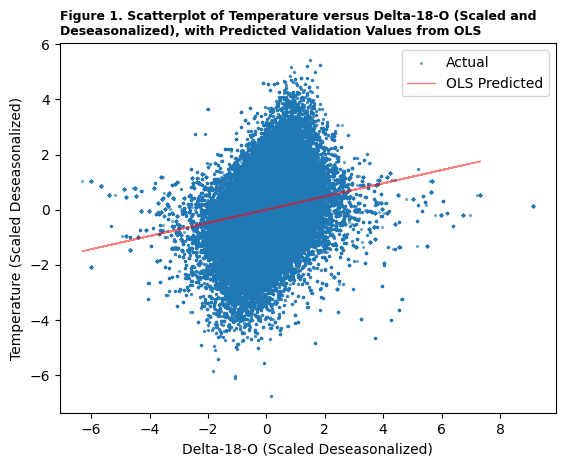

In [57]:
# Create a dataframe with variables for the plot 
plot_ols_preds_df = ols_preds_ds[['scaled_deseas_d18O_pr', 'scaled_deseas_tmp2m', 'pred_scaled_deseas_tmp2m']].to_dataframe()

# Add points for the actual values, and a line for the predicted values 
plt.scatter(plot_ols_preds_df['scaled_deseas_d18O_pr'], plot_ols_preds_df['scaled_deseas_tmp2m'], label='Actual',  s=2, alpha=0.5)
plt.plot(plot_ols_preds_df['scaled_deseas_d18O_pr'], plot_ols_preds_df['pred_scaled_deseas_tmp2m'], label='OLS Predicted', color='red', linewidth=1, alpha=0.5)

# Add a title and axes labels 
plt.title('Figure 1. Scatterplot of Temperature versus Delta-18-O (Scaled and \nDeseasonalized), with Predicted Validation Values from OLS', 
          loc='left', size=9, fontweight='bold')
plt.xlabel('Delta-18-O (Scaled Deseasonalized)')
plt.ylabel('Temperature (Scaled Deseasonalized)')
plt.legend()

plt.show()

### 4. Save Predictions 

The code below saves the datasets containing the mean and OLS predictions created in steps (2) and (3) as netCDF files in the `MDS_Antarctica/notebooks/demo_outputs/` folder. These netCDF files can  be loaded easily later on to perform post-processing and evaluation. 

In [59]:
# Save mean and OLS baseline predictions as netCDF files 

############ EDIT THIS PATH 
output_path = './notebooks/demo_outputs/'
########################### 

mean_preds_ds.to_netcdf(output_path + 'latlonmonth_mean_preds.nc')
ols_preds_ds.to_netcdf(output_path + 'ols_preds.nc')

### 5. Post-process / Evaluate Predictions

This section utilizes the `Postprocessing.utils` code to evaluate the predictions generated. 

---

First, we must load our saved netCDF prediction files as xarray datasets as inputs to the Post-processing pipeline. Make sure `preds_path` in the code cell below points to the location where we saved our mean and OLS predictions in step (4):

In [60]:
# Load the predictions that we saved in step (4) 

############ EDIT THIS PATH 
preds_path = './notebooks/demo_outputs/'
########################### 

mean_preds_ds = xr.open_dataset(preds_path + 'latlonmonth_mean_preds.nc')
ols_preds_ds = xr.open_dataset(preds_path + 'ols_preds.nc')

#### RMSEs

The following code cells use `calculate_residuals()` and `calculate_model_RMSE()` from the `Postprocessing.utils` module to compute the Root Mean Squared Error (RMSE, see equation (1) below) scores from the validation predictions of the mean and OLS baseline model, respectively. 

RMSE equation: 

$$\text{RMSE} = \sqrt{\frac{\sum_{i=1}^{n}(y_i^{\text{(anomaly, scaled)}}- \hat{y}_i^{(anomaly, scaled)})^2}{n}} \,\,\,\,\,\,\text{(1)}$$

Where: 

- $y_i$: the true y-value
- $\hat{y}_i$: the predicted y-value
- $n$: the number of examples

Smaller RMSE values indicate less errors, or more accurate predictions.

In [61]:
# Mean baseline

# Compute the residuals 
mean_preds_resids = calculate_residuals(mean_preds_ds)

# Compute the RMSE score
mean_preds_RMSEs = calculate_model_RMSE(mean_preds_resids)

# Show results
mean_preds_RMSEs

{'scaled_deseas_tmp2m': 1.0283230863485289}

In [62]:
# OLS baseline

# Compute the residuals 
ols_preds_resids = calculate_residuals(ols_preds_ds)

# Compute the RMSE scores
ols_preds_RMSEs = calculate_model_RMSE(ols_preds_resids)

# Show results
ols_preds_RMSEs

{'scaled_deseas_tmp2m': 0.9875581934944327}

The code below displays a table to compare the RMSE scores of the two baseline models. 
- It appears that the validation RMSE for the OLS baseline model is slightly lower/better than when predicting the latitude-longitude-month mean. 

In [63]:
# Create a dataframe comparing mean and OLS RMSE scores
RMSE_df = pd.DataFrame()
RMSE_df['Baseline'] = ['latlonmonth_mean', 'OLS']
RMSE_df['RMSE'] = [mean_preds_RMSEs['scaled_deseas_tmp2m'], ols_preds_RMSEs['scaled_deseas_tmp2m']]

# Display the table 
display(Markdown(f'**{"Table 4. Validation RMSE Scores for Temperature (Scaled Deseasonalized) for Baseline Models"}**'))
display(RMSE_df)

**Table 4. Validation RMSE Scores for Temperature (Scaled Deseasonalized) for Baseline Models**

,Baseline,RMSE
0,latlonmonth_mean,1.028323
1,OLS,0.987558


#### Residual Plots

A residual is the difference between the true y-value and the predicted y-value: 

$$y^{residual}_i = y_i - \hat{y}_i \,\,\,\,\,\,\text{(2)}$$

Where:

- $y_i$: the true y-value
- $\hat{y}_i$: the predicted y-value

More negative residuals indicates that the model is overpredicting ($\hat{y}_i$ > $y_i$), whereas more positive residuals indicates that the model is underpredicting ($\hat{y}_i$ < $y_i$).

---

The following code uses the `generate_residual_plots()` method from `Postprocessing.utils` to create plots for the mean baseline model. 
- From the top left "Average Residuals (accuracy)" plot, it appears that there are low average residual scores across Antarctica.
- However, from the bottom left "Std. Dev. of Residuals (precision)" plot, there appears to be low precision (dark blues) around the Western sea and East Antarctica regions. 
- From the top right "Average Residuals by Month" plot, there do not seem to be any large seasonal patterns.
- From the bottom right histogram, the residuals do not appear to be skewed positively or negatively. 

Figure 2. Residual Plots for Latitude-Longitude-Month Mean Baseline Predicting Temperature Anomalies


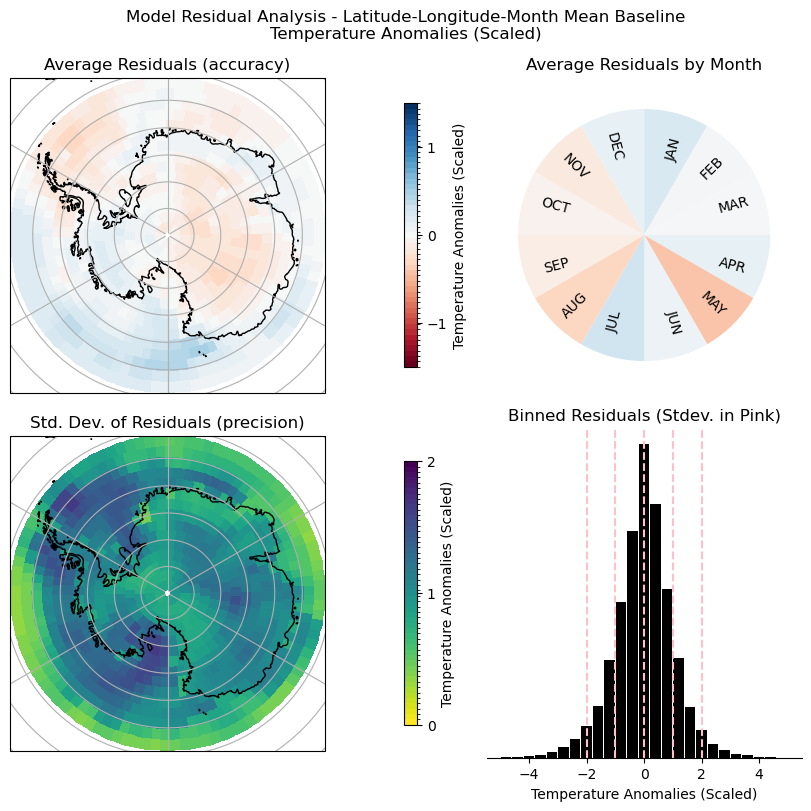

<Figure size 640x480 with 0 Axes>

In [70]:
# Mean baseline
print("Figure 2. Residual Plots for Latitude-Longitude-Month Mean Baseline Predicting Temperature Anomalies")
generate_residual_plots(mean_preds_resids, 
                        variable = 'resid_scaled_deseas_tmp2m', 
                        label = 'Temperature Anomalies (Scaled)', 
                        model_name = 'Latitude-Longitude-Month Mean Baseline',
                        out_file = './notebooks/demo_outputs/',
                        #show_plot = False
                       )

The code cell below creates plots for the OLS baseline model. 
- From the top left "Average Residuals (accuracy)" plot, it again appears that there are low average residual scores across Antarctica, with more over prediction (red hues, negative residuals) around the East of the continent.
- From the bottom left "Std. Dev. of Residuals (precision)" plot, we again see that there appears to be lower precision (dark blues) around the Western sea and East Antarctica regions. 
- The top right "Average Residuals by Month" plot does not seem to show strong seasonal patterns.
- From the bottom right histogram, the residuals do not appear to be skewed positively or negatively. 

Figure 3. Residual Plots for OLS Baseline Predicting Temperature Anomalies


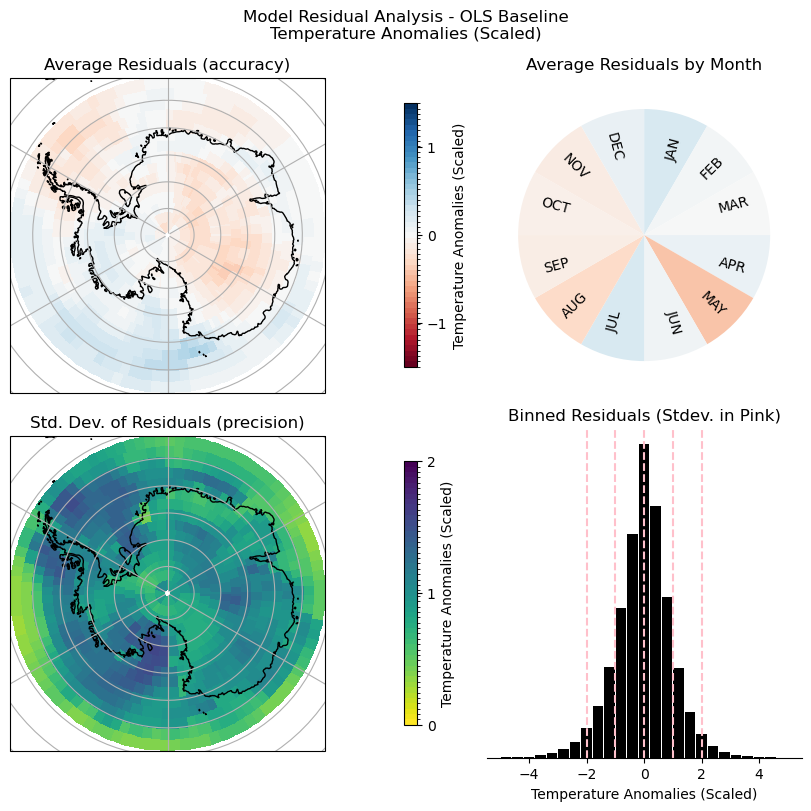

<Figure size 640x480 with 0 Axes>

In [71]:
# OLS baseline
print("Figure 3. Residual Plots for OLS Baseline Predicting Temperature Anomalies")
generate_residual_plots(ols_preds_resids, 
                        variable = 'resid_scaled_deseas_tmp2m', 
                        label = 'Temperature Anomalies (Scaled)', 
                        model_name = 'OLS Baseline',
                        out_file = './notebooks/demo_outputs/',
                        #show_plot = False
                       )

## References 

Stenni, Barbara, Mark AJ Curran, Nerilie J Abram, Anais Orsi, Sentia Goursaud, Valerie Masson- Delmotte, Raphael Neukom, et al. 2017. “Antarctic Climate Variability on Regional and Continental Scales over the Last 2000 Years.” Climate of the Past 13 (11): 1609–34.